# 07. PyTorch Experiment Tracking

## 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu117
torchvision version: 0.15.2+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine


/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """
    Sets random seeds for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get data

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str,
                  destination: str,
                  remove_source: bool=True) -> Path:
    """
    Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destinatoin (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi") 
    """
    # Setup path to data folder
    data_path = Path('data/')
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f'[INFO] {image_path} directory exists, skipping download.')
    else:
        print(f'[INFO] Did not find {image_path} directory, creating one...')
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f'[INFO] Downloading {target_file} from {source}...')
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, 'r') as zip_ref:
            print(f'[INFO] Unzipping {target_file} data...')
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders using manually created transforms

In [6]:
# Setup directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f'Manually created transforms: {manual_transforms}')

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f39c41f7150>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

In [7]:
# Setup dirs
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f'Automatically created transforms: {automatic_transforms}')

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatically created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f39c407ecd0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [8]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [9]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear), let's set the seeds
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True).to(device))

In [10]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
# summary(model, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
#         verbose=0,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

## 4. Train model and track results

In [11]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [13]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch model through train_step() and test_step() functions for a number of epochs, training and testing the model in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimzier: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. 'cuda' or 'cpu').

    Returns:
        A dictionary of training and testing loss as well as training and testing accuracy metrics. Each metric has a value in a list for each epoch.
        In the form: {train_loss: [...],
                      train_acc: [...],
                      test_loss: [...],
                      test_acc: [...]}.
        For example if training for epochs=2:
                     {train_loss: [2.0616, 1.0537],
                      train_acc: [0.3945, 0.3645],
                      test_loss: [1.2651, 1.5706],
                      test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        
        # Print out what's happening
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag='Loss',
                           tag_scalar_dict={'train_loss': train_loss,
                                            'test_loss': test_loss},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

    ### End new ###
    
    # Return the filled results at the end of the epochs
    return results

In [14]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | test_loss: 0.8842 | test_acc: 0.6903


 20%|██        | 1/5 [00:03<00:13,  3.46s/it]

Epoch: 2 | train_loss: 0.8680 | test_loss: 0.7807 | test_acc: 0.8030


 40%|████      | 2/5 [00:06<00:09,  3.09s/it]

Epoch: 3 | train_loss: 0.8556 | test_loss: 0.7099 | test_acc: 0.8362


 60%|██████    | 3/5 [00:09<00:06,  3.02s/it]

Epoch: 4 | train_loss: 0.7164 | test_loss: 0.6508 | test_acc: 0.8542


 80%|████████  | 4/5 [00:12<00:02,  2.94s/it]

Epoch: 5 | train_loss: 0.6000 | test_loss: 0.5722 | test_acc: 0.8759


100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


In [15]:
# Check out the model results
results

{'train_loss': [1.096208281815052,
  0.8680475205183029,
  0.8555576950311661,
  0.7163794636726379,
  0.599950548261404],
 'train_acc': [0.390625, 0.765625, 0.6640625, 0.78125, 0.88671875],
 'test_loss': [0.8842393557230631,
  0.7806802988052368,
  0.7098699808120728,
  0.6508458654085795,
  0.5722275972366333],
 'test_acc': [0.6903409090909092,
  0.8030303030303031,
  0.8361742424242425,
  0.8541666666666666,
  0.8759469696969697]}

## 5. View our model's results in TensorBoard

In [16]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
# %load_ext tensorboard
# %tensorboard --logdir runs

## 6. Create a helper function to build SummaryWriter() instances

In [17]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to 'runs/2022-06-04/data_10_percent/effnetb2/5_epochs/'
        writer = create_writer(experiment_name='data_10_percent',
                               model_name='effnetb2',
                               extra='5_epochs')
        # The above is the same as:
        writer = SummaryWriter(log_dir='runs/2022-06-04/data_10_percent/effnetb2/5_epochs/')
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime('%Y-%m-%d') # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)

    print(f'[INFO] Created SummaryWriter, saving to: {log_dir}...')
    return SummaryWriter(log_dir=log_dir)

In [18]:
# Create an example writer
example_writer = create_writer(experiment_name='data_10_percent',
                               model_name='effnetb0',
                               extra='5_epochs')

[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_10_percent/effnetb0/5_epochs...


### 6.1 Update the `train()` function to include a `writer` parameter

In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch model through train_step() and test_step() functions for a number of epochs, training and testing the model in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimzier: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. 'cuda' or 'cpu').

    Returns:
        A dictionary of training and testing loss as well as training and testing accuracy metrics. Each metric has a value in a list for each epoch.
        In the form: {train_loss: [...],
                      train_acc: [...],
                      test_loss: [...],
                      test_acc: [...]}.
        For example if training for epochs=2:
                     {train_loss: [2.0616, 1.0537],
                      train_acc: [0.3945, 0.3645],
                      test_loss: [1.2651, 1.5706],
                      test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        
        # Print out what's happening
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        ### New: Use the writer parameter to track experiments ###
        # See if ther's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag='Loss',
                            tag_scalar_dict={'train_loss': train_loss,
                                                'test_loss': test_loss},
                            global_step=epoch)
            writer.add_scalars(main_tag='Accuracy',
                               tag_scalar_dict={'train_acc': train_acc,
                                                'test_acc': test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###
    
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [21]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / 'train'
train_dir_20_percent = data_20_percent_path / 'train'

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / 'test'

# Check the directories
print(f'Training directory 10% : {train_dir_10_percent}')
print(f'Training directory 20% : {train_dir_20_percent}')
print(f'Testing directory: {test_dir}')

Training directory 10% : data/pizza_steak_sushi/train
Training directory 20% : data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoaders

In [22]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [23]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f'Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}')
print(f'Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}')
print(f'Number fo batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)')
print(f'Number of classes: {len(class_names)}, class names: {class_names}')

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number fo batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

In [24]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # 'DEFAULT' means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f'Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()["1.weight"][0])}')

Number of in_features to final layer of EfficientNetB2: 1408


In [25]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Get an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = 'effnetb0'
    print(f'[INFO] Created new {model.name} model.')
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = 'effnetb2'
    print(f'[INFO] Created new {model.name} model.')
    return model

In [26]:
effnetb0 = create_effnetb0()

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [27]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code

In [28]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {'data_10_percent': train_dataloader_10_percent,
                     'data_20_percent': train_dataloader_20_percent}

In [29]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs:

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f'[INFO] Experiment number: {experiment_number}')
            print(f'[INFO] Model: {model_name}')
            print(f'[INFO] DataLoader: {dataloader_name}')
            print(f'[INFO] Number of epochs: {epochs}')

            # 7. Select the model
            if model_name == 'effnetb0':
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)

            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f'{epochs}_epochs'))

            # 10. Save the model to file so we can get back the best model
            save_filepath = f'07_{model_name}_{dataloader_name}_{epochs}_epochs.pth'
            save_model(model=model,
                    target_dir='models',
                    model_name=save_filepath)
            print('-'*50 + '\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_10_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:01<00:07,  1.83s/it]

Epoch: 1 | train_loss: 1.0528 | test_loss: 0.8720 | test_acc: 0.5672


 40%|████      | 2/5 [00:03<00:05,  1.84s/it]

Epoch: 2 | train_loss: 0.9239 | test_loss: 0.7689 | test_acc: 0.7424


 60%|██████    | 3/5 [00:05<00:03,  1.83s/it]

Epoch: 3 | train_loss: 0.7693 | test_loss: 0.6392 | test_acc: 0.9167


 80%|████████  | 4/5 [00:07<00:01,  1.84s/it]

Epoch: 4 | train_loss: 0.7055 | test_loss: 0.6586 | test_acc: 0.8570


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


Epoch: 5 | train_loss: 0.7054 | test_loss: 0.5751 | test_acc: 0.8769
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_10_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [00:02<00:08,  2.18s/it]

Epoch: 1 | train_loss: 1.0928 | test_loss: 0.9427 | test_acc: 0.6809


 40%|████      | 2/5 [00:04<00:06,  2.17s/it]

Epoch: 2 | train_loss: 0.8966 | test_loss: 0.8357 | test_acc: 0.7831


 60%|██████    | 3/5 [00:06<00:04,  2.15s/it]

Epoch: 3 | train_loss: 0.8247 | test_loss: 0.7738 | test_acc: 0.8153


 80%|████████  | 4/5 [00:08<00:02,  2.14s/it]

Epoch: 4 | train_loss: 0.7367 | test_loss: 0.7566 | test_acc: 0.8153


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch: 5 | train_loss: 0.7271 | test_loss: 0.6824 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_10_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

Epoch: 1 | train_loss: 1.0528 | test_loss: 0.8720 | test_acc: 0.5672


 20%|██        | 2/10 [00:03<00:14,  1.84s/it]

Epoch: 2 | train_loss: 0.9239 | test_loss: 0.7689 | test_acc: 0.7424


 30%|███       | 3/10 [00:05<00:12,  1.84s/it]

Epoch: 3 | train_loss: 0.7693 | test_loss: 0.6392 | test_acc: 0.9167


 40%|████      | 4/10 [00:07<00:10,  1.83s/it]

Epoch: 4 | train_loss: 0.7055 | test_loss: 0.6586 | test_acc: 0.8570


 50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

Epoch: 5 | train_loss: 0.7054 | test_loss: 0.5751 | test_acc: 0.8769


 60%|██████    | 6/10 [00:10<00:07,  1.80s/it]

Epoch: 6 | train_loss: 0.5830 | test_loss: 0.5427 | test_acc: 0.8873


 70%|███████   | 7/10 [00:12<00:05,  1.80s/it]

Epoch: 7 | train_loss: 0.5511 | test_loss: 0.4996 | test_acc: 0.9271


 80%|████████  | 8/10 [00:14<00:03,  1.80s/it]

Epoch: 8 | train_loss: 0.4796 | test_loss: 0.4751 | test_acc: 0.8968


 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

Epoch: 9 | train_loss: 0.4571 | test_loss: 0.5105 | test_acc: 0.8570


100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


Epoch: 10 | train_loss: 0.5389 | test_loss: 0.4924 | test_acc: 0.8570
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_10_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:02<00:18,  2.10s/it]

Epoch: 1 | train_loss: 1.0928 | test_loss: 0.9427 | test_acc: 0.6809


 20%|██        | 2/10 [00:04<00:16,  2.12s/it]

Epoch: 2 | train_loss: 0.8966 | test_loss: 0.8357 | test_acc: 0.7831


 30%|███       | 3/10 [00:06<00:14,  2.12s/it]

Epoch: 3 | train_loss: 0.8247 | test_loss: 0.7738 | test_acc: 0.8153


 40%|████      | 4/10 [00:08<00:12,  2.14s/it]

Epoch: 4 | train_loss: 0.7367 | test_loss: 0.7566 | test_acc: 0.8153


 50%|█████     | 5/10 [00:10<00:10,  2.15s/it]

Epoch: 5 | train_loss: 0.7271 | test_loss: 0.6824 | test_acc: 0.8759


 60%|██████    | 6/10 [00:12<00:08,  2.15s/it]

Epoch: 6 | train_loss: 0.6050 | test_loss: 0.6645 | test_acc: 0.8873


 70%|███████   | 7/10 [00:14<00:06,  2.15s/it]

Epoch: 7 | train_loss: 0.5356 | test_loss: 0.5976 | test_acc: 0.8864


 80%|████████  | 8/10 [00:17<00:04,  2.15s/it]

Epoch: 8 | train_loss: 0.5072 | test_loss: 0.6129 | test_acc: 0.8769


 90%|█████████ | 9/10 [00:19<00:02,  2.15s/it]

Epoch: 9 | train_loss: 0.5476 | test_loss: 0.6188 | test_acc: 0.9072


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

Epoch: 10 | train_loss: 0.4853 | test_loss: 0.5118 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_20_percent/effnetb0/5_epochs...


 20%|██        | 1/5 [00:02<00:09,  2.48s/it]

Epoch: 1 | train_loss: 0.9576 | test_loss: 0.6536 | test_acc: 0.8655


 40%|████      | 2/5 [00:04<00:07,  2.43s/it]

Epoch: 2 | train_loss: 0.6833 | test_loss: 0.5427 | test_acc: 0.9375


 60%|██████    | 3/5 [00:07<00:04,  2.42s/it]

Epoch: 3 | train_loss: 0.5723 | test_loss: 0.4492 | test_acc: 0.9375


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

Epoch: 4 | train_loss: 0.5319 | test_loss: 0.4709 | test_acc: 0.8674


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch: 5 | train_loss: 0.4489 | test_loss: 0.3799 | test_acc: 0.9081
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_20_percent/effnetb2/5_epochs...


 20%|██        | 1/5 [00:02<00:11,  3.00s/it]

Epoch: 1 | train_loss: 0.9830 | test_loss: 0.7681 | test_acc: 0.8551


 40%|████      | 2/5 [00:05<00:08,  3.00s/it]

Epoch: 2 | train_loss: 0.7320 | test_loss: 0.6456 | test_acc: 0.8561


 60%|██████    | 3/5 [00:08<00:05,  2.97s/it]

Epoch: 3 | train_loss: 0.6011 | test_loss: 0.5454 | test_acc: 0.9375


 80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

Epoch: 4 | train_loss: 0.4874 | test_loss: 0.5096 | test_acc: 0.9186


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch: 5 | train_loss: 0.4786 | test_loss: 0.4505 | test_acc: 0.9479
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_20_percent/effnetb0/10_epochs...


 10%|█         | 1/10 [00:02<00:21,  2.39s/it]

Epoch: 1 | train_loss: 0.9576 | test_loss: 0.6536 | test_acc: 0.8655


 20%|██        | 2/10 [00:04<00:18,  2.37s/it]

Epoch: 2 | train_loss: 0.6833 | test_loss: 0.5427 | test_acc: 0.9375


 30%|███       | 3/10 [00:07<00:16,  2.37s/it]

Epoch: 3 | train_loss: 0.5723 | test_loss: 0.4492 | test_acc: 0.9375


 40%|████      | 4/10 [00:09<00:14,  2.36s/it]

Epoch: 4 | train_loss: 0.5319 | test_loss: 0.4709 | test_acc: 0.8674


 50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

Epoch: 5 | train_loss: 0.4489 | test_loss: 0.3799 | test_acc: 0.9081


 60%|██████    | 6/10 [00:14<00:09,  2.36s/it]

Epoch: 6 | train_loss: 0.4661 | test_loss: 0.3473 | test_acc: 0.8977


 70%|███████   | 7/10 [00:16<00:07,  2.36s/it]

Epoch: 7 | train_loss: 0.3623 | test_loss: 0.3068 | test_acc: 0.9072


 80%|████████  | 8/10 [00:18<00:04,  2.36s/it]

Epoch: 8 | train_loss: 0.3393 | test_loss: 0.2854 | test_acc: 0.9583


 90%|█████████ | 9/10 [00:21<00:02,  2.35s/it]

Epoch: 9 | train_loss: 0.3388 | test_loss: 0.3584 | test_acc: 0.8778


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


Epoch: 10 | train_loss: 0.3593 | test_loss: 0.2844 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2023-09-18/data_20_percent/effnetb2/10_epochs...


 10%|█         | 1/10 [00:03<00:27,  3.02s/it]

Epoch: 1 | train_loss: 0.9830 | test_loss: 0.7681 | test_acc: 0.8551


 20%|██        | 2/10 [00:06<00:24,  3.01s/it]

Epoch: 2 | train_loss: 0.7320 | test_loss: 0.6456 | test_acc: 0.8561


 30%|███       | 3/10 [00:09<00:20,  2.99s/it]

Epoch: 3 | train_loss: 0.6011 | test_loss: 0.5454 | test_acc: 0.9375


 40%|████      | 4/10 [00:11<00:17,  2.99s/it]

Epoch: 4 | train_loss: 0.4874 | test_loss: 0.5096 | test_acc: 0.9186


 50%|█████     | 5/10 [00:14<00:14,  3.00s/it]

Epoch: 5 | train_loss: 0.4786 | test_loss: 0.4505 | test_acc: 0.9479


 60%|██████    | 6/10 [00:17<00:11,  2.99s/it]

Epoch: 6 | train_loss: 0.4264 | test_loss: 0.4464 | test_acc: 0.9186


 70%|███████   | 7/10 [00:20<00:08,  2.99s/it]

Epoch: 7 | train_loss: 0.3488 | test_loss: 0.3759 | test_acc: 0.9072


 80%|████████  | 8/10 [00:23<00:05,  2.98s/it]

Epoch: 8 | train_loss: 0.3337 | test_loss: 0.3938 | test_acc: 0.9384


 90%|█████████ | 9/10 [00:26<00:02,  2.99s/it]

Epoch: 9 | train_loss: 0.3379 | test_loss: 0.4187 | test_acc: 0.9489


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]

Epoch: 10 | train_loss: 0.3585 | test_loss: 0.3551 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------

CPU times: user 1min 9s, sys: 48.5 s, total: 1min 58s
Wall time: 2min 21s


## 8. View experiments in TensorBoard

In [30]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

In [31]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

## 9. Load in the best model and make predictions with it

In [32]:
# Setup the best model filepath
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [33]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f'EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB')

EfficientNetB2 feature extractor model size: 29 MB


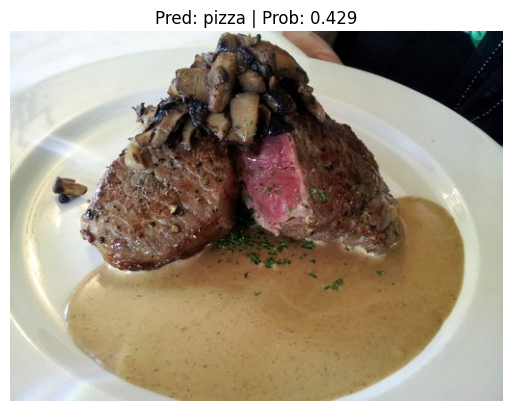

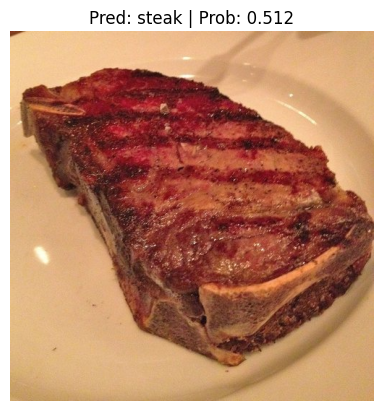

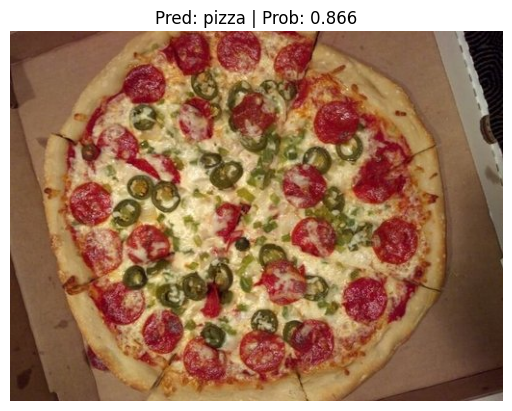

In [34]:
# Import function to make predictions on images and plot them
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.utils import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot  = 3
test_image_path_list = list(Path(data_20_percent_path / 'test').glob('*/*.jpg')) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predicitons on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        device=device)
    plt.show()

### 9.1 Predict on a custom image with the best model

data/04-pizza-dad.jpeg already exists, skipping download.


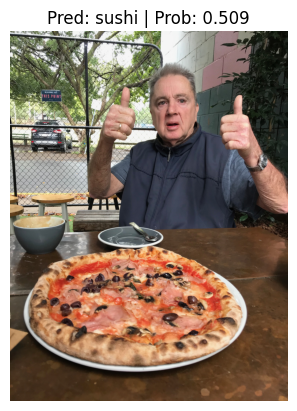

In [35]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    device=device)